In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import logging
import os
import sys

import time
from datetime import timedelta
import prettytensor as pt

In [2]:
trial_version = 'cnn-ver-3'

logdirectory = "./logs/"+trial_version+"/"
if not os.path.exists(logdirectory):
    os.makedirs(logdirectory)
    
logging.basicConfig(
    filename=logdirectory+'data_export_'+trial_version+'.csv', filemode='w',
    level=logging.DEBUG, 
    format='%(asctime)s,%(step)s,%(minibatch_loss)s,%(minibatch_accuracy)s,'+\
            '%(validation_accuracy)s,%(test_accuracy)s',
    datefmt='%m/%d/%Y %I:%M:%S %p')

# File mames for saving and restoring the model
saver_filename= logdirectory+"model_"+trial_version

In [3]:
print(tf.__version__)
print(sys.version)

0.12.1
2.7.13 |Anaconda custom (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [4]:
pickle_file = 'SVHN_real.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (26721, 54, 54, 3) (26721,)
Validation set (6681, 54, 54, 3) (6681,)
Test set (13068, 54, 54, 3) (13068,)


In [5]:
# This is adapted from: 
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/03_PrettyTensor.ipynb

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = cls_true[i]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = cls_pred[i]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

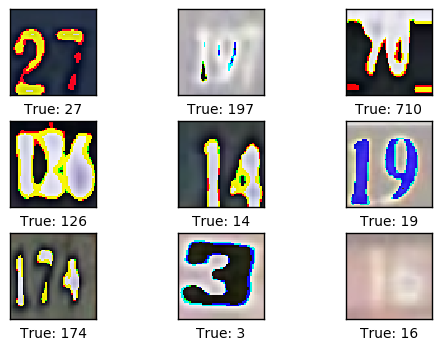

In [6]:
# Get the first images from the test-set.
images = test_dataset[0:9]

# Get the true classes for those images.
cls_true = test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

In [7]:
# Helper function for getting the nth digit from an integer
# For example nth_digit(2534,2) = 5

def nth_digit(number,n):
    l = len(str(number))
    if l >= n:
        return int(str(number)[n-1])
    else:
        return 10

In [8]:
image_size = 54
num_labels = 11
num_channels = 3

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)

  # get the number of digits in the house number, e.g. 218 has labels_num_length=3
  labels_num_length = np.asarray(map(lambda x:len(str(x)), labels))
  
  # get the individual digits from the house number, 10 mean blank
  # For example label digits for the number 218 are: [2,1,8,10,10] 
  labels_digit1 = np.asarray(map(lambda x:nth_digit(x,1), labels))
  labels_digit2 = np.asarray(map(lambda x:nth_digit(x,2), labels))
  labels_digit3 = np.asarray(map(lambda x:nth_digit(x,3), labels))
  labels_digit4 = np.asarray(map(lambda x:nth_digit(x,4), labels))
  labels_digit5 = np.asarray(map(lambda x:nth_digit(x,5), labels))

  # Turn the labels above into 1-hot encodings
  labels_num_length = (np.arange(num_labels) == labels_num_length[:,None]).astype(np.int32)
  labels_digit1 = (np.arange(num_labels) == labels_digit1[:,None]).astype(np.int32)
  labels_digit2 = (np.arange(num_labels) == labels_digit2[:,None]).astype(np.int32)
  labels_digit3 = (np.arange(num_labels) == labels_digit3[:,None]).astype(np.int32)
  labels_digit4 = (np.arange(num_labels) == labels_digit4[:,None]).astype(np.int32)
  labels_digit5 = (np.arange(num_labels) == labels_digit5[:,None]).astype(np.int32)

  # Combine the individual 1-hot encodings into a single matrix
  labels_list = np.stack(
        (labels_num_length, labels_digit1, labels_digit2, 
         labels_digit3, labels_digit4, labels_digit5), axis=1)
  return dataset, labels_list

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (26721, 54, 54, 3) (26721, 6, 11)
Validation set (6681, 54, 54, 3) (6681, 6, 11)
Test set (13068, 54, 54, 3) (13068, 6, 11)


In [9]:
print(test_labels[8]) # compare with the last example image above

[[0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]]


In [10]:
def ohe_to_housenumbers(ohe_labels):
    lengths = ohe_labels[:,0,:]
    digits1 = ohe_labels[:,1,:]
    digits2 = ohe_labels[:,2,:]
    digits3 = ohe_labels[:,3,:]
    digits4 = ohe_labels[:,4,:]
    digits5 = ohe_labels[:,5,:]
    
    num_labels = len(ohe_labels)
    housenumbers = np.zeros(shape=num_labels, dtype=np.int)
    
    for i in range(num_labels):
        l = np.argmax(lengths[i])
        d1 = np.argmax(digits1[i])
        d2 = np.argmax(digits2[i])
        d3 = np.argmax(digits3[i])
        d4 = np.argmax(digits4[i])
        d5 = np.argmax(digits5[i])
        d = str(d1)+str(d2)+str(d3)+str(d4)+str(d5)
        housenumbers[i] = int(d[:min(l,5)])
        
    return housenumbers

In [11]:
print(ohe_to_housenumbers(test_labels[:9])) # compare with example images above


[ 27 197 710 126  14  19 174   3  16]


In [12]:
num_labels = 11 # digits 0-9 and 10 for blank
num_logits = 6 # 5 digits plus number length
num_channels = 3 # RGB color image

In [13]:
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, num_logits,num_labels], name='y_true')

In [14]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        network_base = x_pretty.\
            apply(tf.image.rgb_to_grayscale).\
            conv2d(kernel=5, depth=48, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=128, name='layer_conv3', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=160, name='layer_conv4', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            dropout(0.95).\
            flatten().\
            fully_connected(size=2048, name='layer_fc1').\
            dropout(0.95).\
            fully_connected(size=1024, name='layer_fc2')
        y_pred1, loss1 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,0,:])
        y_pred2, loss2 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,1,:])
        y_pred3, loss3 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,2,:])
        y_pred4, loss4 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,3,:])
        y_pred5, loss5 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,4,:])
        y_pred6, loss6 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,5,:])
        loss = pt.create_composite_loss([loss1,loss2,loss3,loss4,loss5,loss6])
        y_pred = tf.pack([y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6],axis=1)
        
    return y_pred, loss

In [15]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [16]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [17]:
_, loss = create_network(training=True)

In [18]:
optimizer = tf.train.AdamOptimizer().minimize(loss,global_step=global_step)

In [19]:
y_pred, _ = create_network(training=False)

In [20]:

saver = tf.train.Saver()

In [21]:
session = tf.Session()


In [22]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=logdirectory)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.initialize_all_variables())

Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Traceback (most recent call last):
  File "/home/hanu/anaconda2/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/home/hanu/anaconda2/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/home/hanu/anaconda2/lib/python2.7/logging/__init__.py", line 469, in format
    s = self._fmt % record.__dict__
KeyError: 'step'
Logged from file deprecation.py, line 109


In [23]:
train_batch_size = 64


In [24]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(train_dataset)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = train_dataset[idx, :, :, :]
    y_batch = train_labels[idx, :]

    return x_batch, y_batch

In [25]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_dataset[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = ohe_to_housenumbers(test_labels[incorrect])
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [26]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = ohe_to_housenumbers(session.run(y_pred, feed_dict=feed_dict))

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [27]:
def predict_cls_test():
    return predict_cls(images = test_dataset,
                       labels = test_labels,
                       cls_true = ohe_to_housenumbers(test_labels))

In [28]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [29]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # Best validation accuracy seen so far.
    best_validation_accuracy = 0.0

    # Iteration-number for last improvement to validation accuracy.
    last_improvement = 0

    # Stop optimization if no improvement found in this many iterations.
    require_improvement = 1000

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        batch_loss, i_global, _ = session.run([loss, global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen at regular intervals (and last).
        if (i_global % 10 == 0) or (i == num_iterations - 1):            
            print('Minibatch loss at step %d: %f' % (i_global, batch_loss))
    
            # Get accuracy on the Mini-batch set
            correct, cls_pred = predict_cls(images = x_batch,
                                            labels = y_true_batch,
                                          cls_true = ohe_to_housenumbers(y_true_batch))
            # Classification accuracy and the number of correct classifications.
            mb_acc, num_correct = classification_accuracy(correct)
            # Number of images being classified.
            num_images = len(correct)
            # Print the accuracy.
            msg = "Accuracy on Mini-batch: {0:.1%} ({1} / {2})"
            print(msg.format(mb_acc, num_correct, num_images))
            d = {'step': i_global, 'minibatch_loss': batch_loss, 'minibatch_accuracy': mb_acc,
             'validation_accuracy': '-', 'test_accuracy': '-'}
            logging.info('logging progress...', extra=d)

        # Save a checkpoint to disk every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            
            # Get accuracy on the validation set
            correct, cls_pred = predict_cls(images = valid_dataset,
                                            labels = valid_labels,
                                          cls_true = ohe_to_housenumbers(valid_labels))
            # Classification accuracy and the number of correct classifications.
            val_acc, num_correct = classification_accuracy(correct)
            # Number of images being classified.
            num_images = len(correct)
            # Print the accuracy.
            d = {'step': i_global, 'minibatch_loss': '-', 'minibatch_accuracy': '-',
             'validation_accuracy': val_acc, 'test_accuracy': '-'}
            logging.info('logging progress...', extra=d)
            
            
            # If validation accuracy is an improvement over best-known.
            if val_acc > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = val_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = i_global

                # Save all variables of the TensorFlow graph to file.
                saver.save(sess=session, save_path=saver_filename,
                       global_step=global_step)
                print("Saved checkpoint.")

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''
            
            msg = "Accuracy on Validation Set: {0:.1%} ({1} / {2}) {3}"
            print(msg.format(val_acc, num_correct, num_images, improved_str))

        # If no improvement found in the required number of iterations.
        if i_global - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")
            # Break out from the for-loop.
            break

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [30]:
def print_test_accuracy(show_example_errors=False):   
    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    
    d = {'step': '-', 'minibatch_loss': '-', 'minibatch_accuracy': '-',
         'validation_accuracy': '-', 'test_accuracy': acc}
    logging.info('logging progress...', extra=d)

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

In [31]:
if True:
    optimize(num_iterations=10000)

Minibatch loss at step 10: 12.454723
Accuracy on Mini-batch: 0.0% (0 / 64)
Minibatch loss at step 20: 8.184209
Accuracy on Mini-batch: 3.1% (2 / 64)
Minibatch loss at step 30: 8.104986
Accuracy on Mini-batch: 0.0% (0 / 64)
Minibatch loss at step 40: 7.401726
Accuracy on Mini-batch: 1.6% (1 / 64)
Minibatch loss at step 50: 7.756386
Accuracy on Mini-batch: 1.6% (1 / 64)
Minibatch loss at step 60: 6.768729
Accuracy on Mini-batch: 0.0% (0 / 64)
Minibatch loss at step 70: 8.305281
Accuracy on Mini-batch: 0.0% (0 / 64)
Minibatch loss at step 80: 7.437799
Accuracy on Mini-batch: 4.7% (3 / 64)
Minibatch loss at step 90: 7.405144
Accuracy on Mini-batch: 0.0% (0 / 64)
Minibatch loss at step 100: 8.336548
Accuracy on Mini-batch: 0.0% (0 / 64)
Saved checkpoint.
Accuracy on Validation Set: 1.6% (107 / 6681) *
Minibatch loss at step 110: 7.467389
Accuracy on Mini-batch: 1.6% (1 / 64)
Minibatch loss at step 120: 7.574416
Accuracy on Mini-batch: 0.0% (0 / 64)
Minibatch loss at step 130: 7.815833
Accur

Accuracy on Test-Set: 72.6% (9485 / 13068)
Example errors:


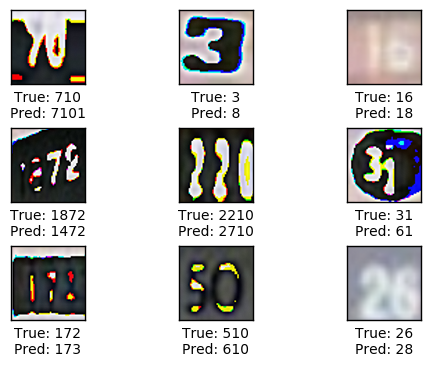

In [32]:
print_test_accuracy(show_example_errors=True)

In [33]:
session.close()